# CycleGAN VC

- https://github.com/pritishyuvraj/Voice-Conversion-GAN

In [1]:
from comet_ml import Experiment

## JVS

In [6]:
!ln -s ./data/jvs_ver1/jvs002 data/src
!ln -s ./data/jvs_ver1/jvs010 data/tgt

In [2]:
!ls data

20170104210653.jpg  20170104210705.jpg	       jvs_ver1  src   tgt
20170104210658.jpg  imagenet_class_index.json  mnist	 svhn


In [3]:
import IPython.display
IPython.display.display(IPython.display.Audio(filename='data/src/VOICEACTRESS100_001.wav', rate=16000))
IPython.display.display(IPython.display.Audio(filename='data/tgt/VOICEACTRESS100_001.wav', rate=16000))

## 前処理

- とりあえずparallelデータのままで訓練してみる
- 実際は、前半の50、後半の50でデータをわける

In [4]:
train_A_dir = './data/src'  # JVS002
train_B_dir = './data/tgt'  # JVS010

In [5]:
import os
import librosa

def load_wavs(wav_dir, sr):
    wavs = list()
    for file in os.listdir(wav_dir):
        file_path = os.path.join(wav_dir, file)
        wav, _ = librosa.load(file_path, sr=sr, mono=True)
        wavs.append(wav)
    return wavs

In [6]:
wavs_A = load_wavs(train_A_dir, sr=16000)
wavs_B = load_wavs(train_B_dir, sr=16000)

In [7]:
import numpy as np
import pyworld
import pysptk
from tqdm import tqdm


def extract_world_features(wave, fs, frame_period=5.0, num_mcep=24):
    f0s = list()
    timeaxes = list()
    sps = list()
    aps = list()
    mceps = list()
    for wav in tqdm(wave):
        wav = wav.astype(np.float64)

        f0, timeaxis = pyworld.harvest(wav, fs, frame_period=frame_period)
        sp = pyworld.cheaptrick(wav, f0, timeaxis, fs)
        ap = pyworld.d4c(wav, f0, timeaxis, fs)

        # 24次元が抽出される
        # メルフィルタを使ってないためmcepではなさそう
        mcep = pyworld.code_spectral_envelope(sp, fs, num_mcep)

#         alpha = pysptk.util.mcepalpha(fs)
#         mcep = pysptk.sp2mc(sp, mcep_order, alpha)

        f0s.append(f0)
        timeaxes.append(timeaxis)
        sps.append(sp)
        aps.append(ap)
        mceps.append(mcep)

    return f0s, timeaxes, sps, aps, mceps

- [difference between pysptk.sp2mc AND pyworld.code_spectral_envelope #74](https://github.com/r9y9/pysptk/issues/74)

In [8]:
num_mcep = 24
sampling_rate = 16000
frame_period = 5.0
n_frames = 128

### lf0, mcep, apの抽出

In [9]:
f0s_A, timeaxes_A, sps_A, aps_A, mceps_A = extract_world_features(wavs_A, fs=sampling_rate, frame_period=frame_period, num_mcep=num_mcep)
f0s_B, timeaxes_B, sps_B, aps_B, mceps_B = extract_world_features(wavs_B, fs=sampling_rate, frame_period=frame_period, num_mcep=num_mcep)

100%|██████████| 100/100 [03:49<00:00,  2.29s/it]


In [10]:
f0s_A[0].shape, sps_A[0].shape, aps_A[0].shape, mceps_A[0].shape

((820,), (820, 513), (820, 513), (820, 24))

### lf0の統計量

In [11]:
def logf0_statistics(f0s):
    # Note: np.ma.log() calculating log on masked array (for incomplete or invalid entries in array)
    log_f0s_concatenated = np.ma.log(np.concatenate(f0s))
    log_f0s_mean = log_f0s_concatenated.mean()
    log_f0s_std = log_f0s_concatenated.std()
    return log_f0s_mean, log_f0s_std

In [12]:
log_f0s_mean_A, log_f0s_std_A = logf0_statistics(f0s_A)
log_f0s_mean_B, log_f0s_std_B = logf0_statistics(f0s_B)
print(log_f0s_mean_A, log_f0s_std_A)
print(log_f0s_mean_B, log_f0s_std_B)

5.360063345512454 0.29044769128393916
5.623051827437946 0.3459336982720282


### mcepの統計量の算出と標準化

In [13]:
def mceps_normalization_fit_transform(mceps):
    mceps_concatenated = np.concatenate(mceps, axis=1)
    mceps_mean = np.mean(mceps_concatenated, axis=1, keepdims=True)
    mceps_std = np.std(mceps_concatenated, axis=1, keepdims=True)
    mceps_normalized = list()
    for mcep in mceps:
        mceps_normalized.append((mcep - mceps_mean) / mceps_std)
    return mceps_normalized, mceps_mean, mceps_std

In [14]:
mceps_A_norm, mceps_A_mean, mceps_A_std = mceps_normalization_fit_transform([x.T for x in mceps_A])
mceps_B_norm, mceps_B_mean, mceps_B_std = mceps_normalization_fit_transform([x.T for x in mceps_B])

In [15]:
mceps_A_norm[0].shape, mceps_A_norm[0].shape

((24, 820), (24, 820))

In [16]:
np.savez('logf0s_normalization.npz',
         mean_A=log_f0s_mean_A,
         std_A=log_f0s_std_A,
         mean_B=log_f0s_mean_B,
         std_B=log_f0s_std_B)

In [17]:
np.savez('mcep_normalization.npz',
         mean_A=mceps_A_mean,
         std_A=mceps_A_std,
         mean_B=mceps_B_mean,
         std_B=mceps_B_std)

In [18]:
import pickle

with open('mceps_A_norm.pickle', 'wb') as f:
    pickle.dump(mceps_A_norm, f)

with open('mceps_B_norm.pickle', 'wb') as f:
    pickle.dump(mceps_B_norm, f)

## Dataset

In [19]:
import numpy as np
import torch
from torch.utils.data.dataset import Dataset

In [105]:
a = [1, 2, 3, 4, 5]
print(a[[0, 2, 4]])

TypeError: list indices must be integers or slices, not list

In [ ]:
a = [np.array()]

In [110]:
class TrainingDataset(Dataset):
    def __init__(self, datasetA, datasetB, n_frames=128):
        # n_framesは切り出すフレーム長
        self.datasetA = datasetA  # list
        self.datasetB = datasetB  # list
        self.n_frames = n_frames

        # データ数の小さい方
        self.num_samples = min(len(datasetA), len(datasetB))

        self.datasetA_idx = np.arange(len(datasetA))
        self.datasetB_idx = np.arange(len(datasetB))
        np.random.shuffle(self.datasetA_idx)
        np.random.shuffle(self.datasetB_idx)

        # src/tgtのデータをランダムにシャッフル
        # パラレルデータを想定しないのでランダムにしてもOK
        self.datasetA = [self.datasetA[i] for i in self.datasetA_idx[:self.num_samples]]
        self.datasetB = [self.datasetB[i] for i in self.datasetB_idx[:self.num_samples]]

    def __getitem__(self, index):
        # srcから音声をランダムに選択
        dataA = self.datasetA[index]
        
        # tgtから音声をランダムに選択
        dataB = self.datasetB[index]

        # n_framesだけランダムに切り出す
        frames_A_total = dataA.shape[1]
        assert frames_A_total >= self.n_frames
        startA = np.random.randint(frames_A_total - self.n_frames + 1)
        endA = startA + self.n_frames
        segmentA = dataA[:, startA:endA]

        frames_B_total = dataB.shape[1]
        assert frames_B_total >= self.n_frames
        startB = np.random.randint(frames_B_total - self.n_frames + 1)
        endB = startB + self.n_frames
        segmentB = dataB[:, startB:endB]
        
        return segmentA, segmentB

    def __len__(self):
        return self.num_samples

In [111]:
# Test
trainA = np.random.randn(162, 24, 554)  # (size, mcep_dim, frame_size)
trainB = np.random.randn(158, 24, 554)
dataset = TrainingDataset(trainA, trainB)
segmentA, segmentB = dataset[0]
print(segmentA.shape, segmentB.shape)

(24, 128) (24, 128)


In [115]:
import pickle

# 標準化したmcepを使ってdatasetを作成する
with open('mceps_A_norm.pickle', 'rb') as f:
    datasetA = pickle.load(f)

with open('mceps_B_norm.pickle', 'rb') as f:
    datasetB = pickle.load(f)

print(len(datasetA), len(datasetB))
print(datasetA[0].shape, datasetA[1].shape)
print(datasetB[0].shape, datasetB[1].shape)

dataset = TrainingDataset(datasetA, datasetB, n_frames=128)
segmentA, segmentB = dataset[0]
print(segmentA.shape, segmentB.shape)

100 100
(24, 820) (24, 1615)
(24, 823) (24, 1722)
(24, 128) (24, 128)


In [116]:
# Test
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)
batch = iter(train_loader).next()
print(batch[0].shape)  # src
print(batch[1].shape)  # tgt

torch.Size([2, 24, 128])
torch.Size([2, 24, 128])


## CycleGAN-VC Model

In [117]:
import torch.nn as nn
import torch
import numpy as np

In [118]:
device = torch.device('cuda:0')

In [119]:
class GLU(nn.Module):
    def __init__(self):
        super(GLU, self).__init__()
        # PyTorchのGLUと何が違う？
    
    def forward(self, input):
        return input * torch.sigmoid(input)

In [120]:
class PixelShuffle(nn.Module):
    def __init__(self, upscale_factor):
        super(PixelShuffle, self).__init__()
        # PyTorchのPixelShuffleは4DTensor入力なので3DTensor入力の自作
        self.upscale_factor = upscale_factor
    
    def forward(self, input):
        n = input.shape[0]
        c_out = input.shape[1] // 2
        w_new = input.shape[2] * 2
        return input.view(n, c_out, w_new)

In [121]:
class ResidualLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualLayer, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels,
                      out_channels,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=padding),
            nn.InstanceNorm1d(num_features=out_channels, affine=True),
            GLU(),
            nn.Conv1d(in_channels=out_channels,
                     out_channels=in_channels,
                     kernel_size=kernel_size,
                     stride=1,
                     padding=padding),
            nn.InstanceNorm1d(num_features=in_channels, affine=True)
        )

    def forward(self, input):
        return input + self.layers(input)

In [122]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 入力はmcepの24次元 (batch, mcep_dim, n_frames)
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=24,
                                             out_channels=128,
                                             kernel_size=15,
                                             stride=1,
                                             padding=7),
                                   GLU())
        
        # Downsample Layer
        # 系列長を短くしていく
        self.downsample1 = self.downsample(in_channels=128,
                                           out_channels=256,
                                           kernel_size=5,
                                           stride=2,
                                           padding=1)
        
        self.downsample2 = self.downsample(in_channels=256,
                                           out_channels=512,
                                           kernel_size=5,
                                           stride=2,
                                           padding=2)
        
        # Residual Blocks
        # ResidualLayerは出力はin_channelsになるので注意
        residual_layers = []
        for i in range(6):
            residual_layers.append(ResidualLayer(in_channels=512,
                                                 out_channels=1024,
                                                 kernel_size=3,
                                                 stride=1,
                                                 padding=1))
        self.residual_layers = nn.ModuleList(residual_layers)
        
        # Upsample Layer
        self.upsample1 = self.upsample(in_channels=512,
                                       out_channels=1024,
                                       kernel_size=5,
                                       stride=1,
                                       padding=2)

        self.upsample2 = self.upsample(in_channels=512,
                                       out_channels=512,
                                       kernel_size=5,
                                       stride=1,
                                       padding=2)
        
        self.last_conv_layer = nn.Conv1d(in_channels=256,
                                         out_channels=24,
                                         kernel_size=15,
                                         stride=1,
                                         padding=7)

    def forward(self, input):
        output = self.conv1(input)
        output = self.downsample1(output)
        output = self.downsample2(output)
        for i in range(6):
            output = self.residual_layers[i](output)
        output = self.upsample1(output)
        output = self.upsample2(output)
        output = self.last_conv_layer(output)
        return output

    def downsample(self, in_channels, out_channels, kernel_size, stride, padding):
        # Conv => InstanceNorm => GLU のブロック
        conv_layer = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding),
                                   nn.InstanceNorm1d(num_features=out_channels, affine=True),
                                   GLU())
        return conv_layer

    def upsample(self, in_channels, out_channels, kernel_size, stride, padding):
        conv_layer = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding),
                                   PixelShuffle(upscale_factor=2),
                                   nn.InstanceNorm1d(num_features=out_channels // 2, affine=True),
                                   GLU())
        return conv_layer

In [123]:
from torchsummary import summary
g = Generator().to(device)
summary(g, (24, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 128]          46,208
               GLU-2             [-1, 128, 128]               0
            Conv1d-3              [-1, 256, 63]         164,096
    InstanceNorm1d-4              [-1, 256, 63]             512
               GLU-5              [-1, 256, 63]               0
            Conv1d-6              [-1, 512, 32]         655,872
    InstanceNorm1d-7              [-1, 512, 32]           1,024
               GLU-8              [-1, 512, 32]               0
            Conv1d-9             [-1, 1024, 32]       1,573,888
   InstanceNorm1d-10             [-1, 1024, 32]           2,048
              GLU-11             [-1, 1024, 32]               0
           Conv1d-12              [-1, 512, 32]       1,573,376
   InstanceNorm1d-13              [-1, 512, 32]           1,024
    ResidualLayer-14              [-1, 

In [124]:
# TEST
g = Generator().to(device)
input = torch.rand((2, 24, 128)).to(device)
output = g(input)
print(output.shape)

torch.Size([2, 24, 128])


In [125]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv_layer1 = nn.Sequential(nn.Conv2d(in_channels=1,
                                                   out_channels=128,
                                                   kernel_size=[3, 3],
                                                   stride=[1, 2],
                                                   padding=[1, 1]),
                                         GLU())
        
        self.downsample1 = self.downsample(in_channels=128,
                                           out_channels=256,
                                           kernel_size=[3, 3],
                                           stride=[2, 2],
                                           padding=[1, 1])
        self.downsample2 = self.downsample(in_channels=256,
                                           out_channels=512,
                                           kernel_size=[3, 3],
                                           stride=[2, 2],
                                           padding=[1, 1])
        self.downsample3 = self.downsample(in_channels=512,
                                           out_channels=1024,
                                           kernel_size=[6, 3],
                                           stride=[1, 2],
                                           padding=[3, 1])
        self.fc = nn.Linear(1024, 1)

    def forward(self, input):
        # discriminatorは4DTensor入力にするためchannelsを追加
        # [batch_size, num_features, num_frames] => [batch_size, 1, num_features, num_frames]
        input = input.unsqueeze(1)
        output = self.conv_layer1(input)
        output = self.downsample1(output)
        output = self.downsample2(output)
        output = self.downsample3(output)
        output = output.permute(0, 2, 3, 1).contiguous()
        output = torch.sigmoid(self.fc(output))
        return output
    
    def downsample(self, in_channels, out_channels, kernel_size, stride, padding):
        conv_layer = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                                   nn.InstanceNorm2d(num_features=out_channels, affine=True),
                                   GLU())
        return conv_layer

In [126]:
from torchsummary import summary
g = Discriminator().to(device)
summary(g, (24, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 24, 64]           1,280
               GLU-2          [-1, 128, 24, 64]               0
            Conv2d-3          [-1, 256, 12, 32]         295,168
    InstanceNorm2d-4          [-1, 256, 12, 32]             512
               GLU-5          [-1, 256, 12, 32]               0
            Conv2d-6           [-1, 512, 6, 16]       1,180,160
    InstanceNorm2d-7           [-1, 512, 6, 16]           1,024
               GLU-8           [-1, 512, 6, 16]               0
            Conv2d-9           [-1, 1024, 7, 8]       9,438,208
   InstanceNorm2d-10           [-1, 1024, 7, 8]           2,048
              GLU-11           [-1, 1024, 7, 8]               0
           Linear-12              [-1, 7, 8, 1]           1,025
Total params: 10,919,425
Trainable params: 10,919,425
Non-trainable params: 0
-------------------------

## Training

In [165]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
print(writer.log_dir)

runs/Oct12_14-39-46_dlgdev0001


In [166]:
num_epochs = 5000
batch_size = 16
device = torch.device('cuda:0')

In [167]:
# dataloader
import pickle
import torch.utils.data

with open('mceps_A_norm.pickle', 'rb') as f:
    datasetA = pickle.load(f)

with open('mceps_B_norm.pickle', 'rb') as f:
    datasetB = pickle.load(f)

train_data = TrainingDataset(datasetA, datasetB, n_frames=128)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=8,
                                           drop_last=False)

In [168]:
# model
generator_A2B = Generator().to(device)
generator_B2A = Generator().to(device)
discriminator_A = Discriminator().to(device)
discriminator_B = Discriminator().to(device)

In [169]:
# loss
criterion = nn.MSELoss()

In [170]:
# initial learning rates
# 論文の設定と同じ
g_lr = 0.0002
d_lr = 0.0001

# learning rate decay
# 最初の200000itersは変えない、次の200000itersは線形に落としていく
g_lr_decay = g_lr / 200000
d_lr_decay = d_lr / 200000
start_decay = 200000

In [171]:
import torch.optim as optim

# optimizer
g_params = list(generator_A2B.parameters()) + list(generator_B2A.parameters())
d_params = list(discriminator_A.parameters()) + list(discriminator_B.parameters())

g_optim = optim.Adam(g_params, lr=g_lr, betas=(0.5, 0.999))
d_optim = optim.Adam(d_params, lr=d_lr, betas=(0.5, 0.999))

In [172]:
# loss weight
cycle_loss_lambda = 10
identity_loss_lambda = 5

In [173]:
def adjust_lr_rate(optimizer, lr, lr_decay):
    new_lr = max(0.0, lr - lr_decay)
    for param_groups in optimizer.param_groups:
        param_groups['lr'] = new_lr
    return new_lr

In [ ]:
import os

# cometml
experiment = Experiment(project_name='voice-conversion-test', auto_metric_logging=False)
experiment.add_tag('cyclegan_vc')

# train
global_iters = 0

for epoch in range(1, num_epochs + 1):
    for i, (realA, realB) in enumerate(train_loader):
        global_iters += 1

#         if global_iters > 10000:
#             identity_loss_lambda = 0

#         if global_iters > start_decay:
#             g_lr = adjust_lr_rate(g_optim, g_lr, g_lr_decay)
#             d_lr = adjust_lr_rate(d_optim, d_lr, d_lr_decay)

        realA, realB = realA.float().to(device), realB.float().to(device)
        
        # train generator
        fakeB = generator_A2B(realA)
        cycleA = generator_B2A(fakeB)
        
        fakeA = generator_B2A(realB)
        cycleB = generator_A2B(fakeA)
        
        identityA = generator_B2A(realA)
        identityB = generator_A2B(realB)
        
        d_fakeA = discriminator_A(fakeA)  # [-1, 7, 8, 1]
        d_fakeB = discriminator_B(fakeB)  # [-1, 7, 8, 1]
        
        # cycle consistency loss
        cycle_loss = torch.mean(torch.abs(realA - cycleA)) + torch.mean(torch.abs(realB - cycleB))
        
        # identity loss
        identity_loss = torch.mean(torch.abs(realA - identityA)) + torch.mean(torch.abs(realB - identityB))
        
        # adversarial loss (fake入力の識別結果が1に近づいてほしい）)
        adv_loss = torch.mean((1 - d_fakeA) ** 2) + torch.mean((1 - d_fakeB) ** 2)
        
        # total generator loss
        g_loss = adv_loss + cycle_loss_lambda * cycle_loss + identity_loss_lambda * identity_loss

        g_optim.zero_grad()
        d_optim.zero_grad()
        g_loss.backward(retain_graph=True)
        g_optim.step()

        writer.add_scalar('g_loss', g_loss.item(), global_iters)
        experiment.log_metric('cycle_loss', cycle_loss.item(), step=global_iters)
        experiment.log_metric('identity_loss', identity_loss.item(), step=global_iters)
        experiment.log_metric('adv_loss', adv_loss.item(), step=global_iters)
        experiment.log_metric('g_loss', g_loss.item(), step=global_iters)

        # train discriminator
        d_realA = discriminator_A(realA)
        d_realB = discriminator_B(realB)
        
        fakeA = generator_B2A(realB)
        d_fake_A = discriminator_A(fakeA)
        
        fakeB = generator_A2B(realA)
        d_fake_B = discriminator_B(fakeB)
        
        d_loss_realA = torch.mean((1 - d_realA) ** 2)        
        d_loss_fakeA = torch.mean((0 - d_fakeA) ** 2)
        d_loss_A = d_loss_realA + d_loss_fakeA

        d_loss_realB = torch.mean((1 - d_realB) ** 2)        
        d_loss_fakeB = torch.mean((0 - d_fakeB) ** 2)
        d_loss_B = d_loss_realB + d_loss_fakeB
        
        d_loss = d_loss_A + d_loss_B
        
        writer.add_scalar('d_loss', d_loss.item(), global_iters)
        experiment.log_metric('d_loss_A', d_loss_A.item(), step=global_iters)
        experiment.log_metric('d_loss_B', d_loss_B.item(), step=global_iters)
        experiment.log_metric('d_loss', d_loss.item(), step=global_iters)

        g_optim.zero_grad()
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
    
    if epoch % 1000 == 0 and epoch != 0:
        print('Epoch {} g_loss: {} d_loss: {}'.format(epoch, g_loss.item(), d_loss.item()))
        checkpoint_path = os.path.join(writer.log_dir, 'checkpoint_epoch{:03d}.pth'.format(epoch))
        torch.save({
            'epoch': epoch,
            'generator_A2B_state_dict': generator_A2B.state_dict(),
            'generator_B2A_state_dict': generator_B2A.state_dict(),
            'discriminator_A_state_dict': discriminator_A.state_dict(),
            'discriminator_B_state_dict': discriminator_B.state_dict(),
            'g_optim': g_optim.state_dict(),
            'd_optim': d_optim.state_dict()
        }, checkpoint_path)
    
experiment.end()

COMET INFO: old comet version (3.1.3) detected. current: 3.2.3 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ai-cometml-voice-my/voice-conversion-test/053060c673734d6b8d5280bf6a263a1e



Epoch 1000 g_loss: 21.860366821289062 d_loss: 0.25840049982070923
Epoch 2000 g_loss: 18.06279182434082 d_loss: 0.20197133719921112
Epoch 3000 g_loss: 14.906182289123535 d_loss: 0.2530404329299927
Epoch 4000 g_loss: 13.613534927368164 d_loss: 0.1746504157781601


## Evaluation

In [175]:
import torch

In [176]:
generator_A2B = Generator().to(device)
generator_A2B.load_state_dict(torch.load('runs/Oct12_14-39-46_dlgdev0001/checkpoint_epoch5000.pth')['generator_A2B_state_dict'])
generator_A2B.eval()

Generator(
  (conv1): Sequential(
    (0): Conv1d(24, 128, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): GLU()
  )
  (downsample1): Sequential(
    (0): Conv1d(128, 256, kernel_size=(5,), stride=(2,), padding=(1,))
    (1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): GLU()
  )
  (downsample2): Sequential(
    (0): Conv1d(256, 512, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): GLU()
  )
  (residual_layers): ModuleList(
    (0): ResidualLayer(
      (layers): Sequential(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): InstanceNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): GLU()
        (3): Conv1d(1024, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fals

In [199]:
src_wav_path = './data/src/VOICEACTRESS100_002.wav'

In [200]:
import librosa
import pyworld
import matplotlib.pyplot as plt

In [201]:
def wav_padding(wav, sr, frame_period, multiple=4):
    assert wav.ndim == 1
    num_frames = len(wav)
    num_frames_padded = int((np.ceil((np.floor(num_frames / (sr * frame_period / 1000)) + 1) / multiple + 1) * multiple - 1) * (sr * frame_period / 1000))
    num_frames_diff = num_frames_padded - num_frames
    num_pad_left = num_frames_diff // 2
    num_pad_right = num_frames_diff - num_pad_left
    wav_padded = np.pad(wav, (num_pad_left, num_pad_right), 'constant', constant_values=0)
    return wav_padded

(134000,)


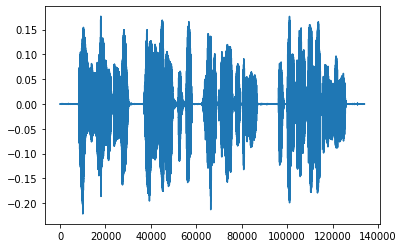

In [202]:
fs = 16000
frame_period = 5.0

wav, _ = librosa.load(src_wav_path, sr=fs, mono=True)
wav = wav_padding(wav, fs, frame_period)
wav = wav.astype(np.float64)
print(wav.shape)
plt.plot(wav)

In [204]:
import IPython.display
IPython.display.display(IPython.display.Audio(data=wav, rate=fs))

In [205]:
f0, timeaxis = pyworld.harvest(wav, fs, frame_period=frame_period)
sp = pyworld.cheaptrick(wav, f0, timeaxis, fs)
ap = pyworld.d4c(wav, f0, timeaxis, fs)

In [206]:
# scaler
logf0s_normalization = np.load('logf0s_normalization.npz')
src_mean = logf0s_normalization['mean_A']
src_std = logf0s_normalization['std_A']
tgt_mean = logf0s_normalization['mean_B']
tgt_std = logf0s_normalization['std_B']
print(src_mean, src_std)
print(tgt_mean, tgt_std)

5.360063345512454 0.29044769128393916
5.623051827437946 0.3459336982720282


In [207]:
# f0の線形変換
f0_converted = np.exp((np.log(f0 + 1e-5) - src_mean) / src_std * tgt_std + tgt_mean)

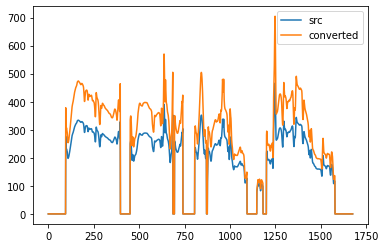

In [210]:
import matplotlib.pyplot as plt
plt.plot(f0, label='src')
plt.plot(f0_converted, label='converted')
plt.legend();

In [211]:
mcep_normalization = np.load('mcep_normalization.npz')
src_mean = mcep_normalization['mean_A']
src_std = mcep_normalization['std_A']
tgt_mean = mcep_normalization['mean_B']
tgt_std = mcep_normalization['std_B']

In [212]:
# スペクトルの変換
mcep = pyworld.code_spectral_envelope(sp, 16000, 24)
mcep = mcep.T
print(mcep.shape)

(24, 1676)


In [213]:
mcep_norm = (mcep - src_mean) / src_std
mcep_norm = torch.from_numpy(mcep_norm).float().to(device)
mcep_norm.unsqueeze_(0)
mcep_norm.shape

torch.Size([1, 24, 1676])

In [214]:
mcep_converted_norm = generator_A2B(mcep_norm)
print(mcep_converted_norm.shape)

torch.Size([1, 24, 1676])


In [215]:
mcep_converted_norm = mcep_converted_norm.cpu().detach().numpy().squeeze()
print(mcep_converted_norm.shape)

(24, 1676)


In [216]:
mcep_converted = mcep_converted_norm * tgt_std + tgt_mean
mcep_converted = mcep_converted.T
mcep_converted = np.ascontiguousarray(mcep_converted)
print(mcep_converted.shape)

(1676, 24)


In [217]:
fftlen = pyworld.get_cheaptrick_fft_size(16000)
demcep_converted = pyworld.decode_spectral_envelope(mcep_converted, 16000, fftlen)
print(demcep_converted.shape)

(1676, 513)


In [218]:
# 音声生成
wav_converted = pyworld.synthesize(f0_converted, demcep_converted, ap, fs, frame_period)
wav_converted = wav_converted.astype(np.float32)

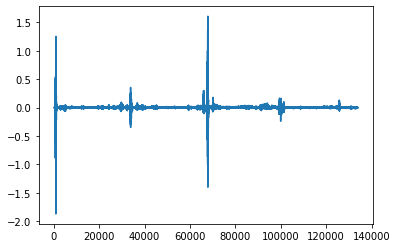

In [219]:
plt.plot(wav_converted)

In [220]:
import IPython.display
IPython.display.display(IPython.display.Audio(data=wav_converted, rate=fs))